In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import pints

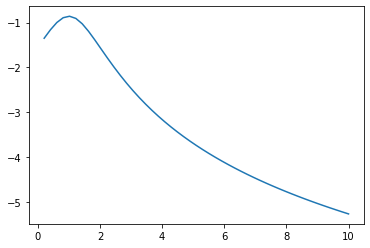

-5.2637670606618725

In [33]:
# Parameters (& hyper parameters)
theta_data = [28, 8, -3, 7, -1, 1, 18, 12] # measured average score for each school
sigma_data = [15, 10, 16, 11, 9, 11, 10, 18] # measured score SD for each school
mu = 1 # overall mean score
tau = 1 # overall score SD

# What is gaussianlogprior?
prior = pints.HalfCauchyLogPrior(mu, tau)
nums = [n/10 for n in np.linspace(0,100)]
test = [prior([n]) for n in nums]
#testcdf = prior.cdf()
plt.figure()
plt.plot(nums, test)
#plt.plot(nums, testcdf)
plt.show()

prior([10])

In [35]:
# Stolen entirely from pints eightschools

def loglikelihood_8schools(x, y_data):
    # x is proposed parameters, we're finding numerator of Bayes' rule
    if len(x) != 10:
        raise ValueError('Input parameters must be of length 10.')
    mu = x[0] # overall mean
    tau = x[1] # overall variance
    thetas = x[2:] # mean per school
    lk_of_theta = 0
    lk_of_data = 0
    # priors
    log_prior = pints.GaussianLogPrior(mu, tau) # prior pdf of theta
    mu_log_prior = pints.GaussianLogPrior(0,5) # prior pdf, centred on zero (no avg effect)
    tau_log_prior = pints.HalfCauchyLogPrior(0,5) # prior pdf, why centre zero???
    
    lk_of_mu = mu_log_prior([mu]) # log likelihood of mu
    lk_of_tau = tau_log_prior([tau]) # log likelihood of tau

    # nb. theta_tilde is the proposed theta (rather than data theta) I think?
    for i, theta_tilde in enumerate(thetas): # go through each proposed school mean
        lk_of_theta += log_prior([theta_tilde]) # log likelihood of theta

        log_prior_2 = pints.GaussianLogPrior(theta_tilde, sigma_data[i]) 
        lk_of_data += log_prior_2([y_data[i]]) # log likelihood of data given theta?

    return lk_of_mu + lk_of_tau + lk_of_theta + lk_of_data

# test
loglikelihood_8schools(np.ones(10), theta_data)

-43.022260381614515

In [57]:
# Pints MCMC
class pints8schools(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 10
    def __call__(self, x, y_data):
        loglikelihood_8schools(x, y_data)

start_thetas = [np.ones(10), np.ones(10)*4, np.ones(10)*9]

mcmc = pints.MCMCController(pints8schools, 3, start_thetas, method=pints.XNES)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

full_chains = mcmc.run()

ValueError: Given function must extend pints.LogPDF

In [49]:
# MCMC without pints. Self-plagiarised wholesale from Bayesian sampling notebook.

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood
        
thetas_8schools = [[np.ones(10)], [np.ones(10)*5], [np.ones(10)]]
covariates_8schools = [1,1,5,5,5,5,5,5,5,5]

model = OdeModel(thetas_8schools, 
                 covariates_8schools, 
                 'where prior goes', 
                 loglikelihood_8schools, 
                 'where ODE would go')

model.thetas[0][-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [38]:
def propose_new_theta(model, y_data, thetas):
    """Randomly proposes a new theta and decides whether to accept or not
    In
    model: instance of OdeModel class
    y_data: list with experimental data
    theta: parameters, in a list
    
    Out: new parameters, either the same (if proposed not accepted) or different
    """
    
    numerator = loglikelihood_8schools(thetas, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = np.zeros(len(thetas))
    for key, value in enumerate(thetas):
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = loglikelihood_8schools(proposed_theta, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta

    if np.random.rand() < proposed_numerator/numerator:
        thetas = proposed_theta
        numerator = proposed_numerator
    else:
        pass # keep thetas the same
    return thetas

In [41]:
def metropolishastings(model, y_data, max_iters):
    iters = 0
    while iters < max_iters:
        for threadnum in range(len(thetas_8schools)):
            theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
            model.thetas[threadnum].append(theta)
        iters = iters + 1

In [50]:
metropolishastings(model, theta_data, 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


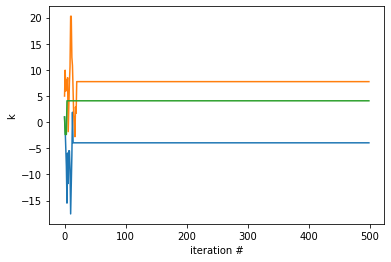

In [52]:
plt.figure()
for n in range(len(model.thetas)):
    ks_list= [theta[3] for theta in model.thetas[n]]
    plt.plot(ks_list[:500]) # only first 500
plt.xlabel('iteration #')
plt.ylabel('k')
plt.show()